In [119]:
# !unzip "drive/MyDrive/DeepFake/Data.zip" -d "drive/MyDrive/DeepFake"

In [120]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version", tf.__version__)
print("TF Hub version", hub.__version__)

#check for the GPU availability
print("GPU, available (YESSSS!!!)" if tf.config.list_physical_devices("GPU") else "GPU not available")

TF version 2.16.1
TF Hub version 0.16.1
GPU not available


In [121]:
#checkout the label of our data using pandas
import pandas as pd


In [122]:
import os
import random
import csv

# Path to the folders containing real and fake images
real_folder = '/Users/lavanyajain/Desktop/Innohacks/Dataset/Train/Real'    #train_real_data
fake_folder = '/Users/lavanyajain/Desktop/Innohacks/Dataset/Train/Fake'    #train_fake_data

# Path to save the CSV file
train_csv_file = '/Users/lavanyajain/Desktop/Innohacks/image_labels_train.csv'
test_csv_file = '/Users/lavanyajain/Desktop/Innohacks/image_labels_test.csv'

# Function to collect image paths and labels
def collect_image_paths(folder, label):
    image_paths = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):  # adjust extensions as necessary
            image_paths.append(os.path.join(folder, filename))
    return [(path, label) for path in image_paths]

# Collect image paths and labels
real_images = collect_image_paths(real_folder, 'real')
fake_images = collect_image_paths(fake_folder, 'fake')

# Shuffle the image paths
random.shuffle(real_images)
random.shuffle(fake_images)

# Split data into train and test sets
split_ratio = 0.8  # 80% training, 20% testing
train_size_real = int(len(real_images) * split_ratio)
train_size_fake = int(len(fake_images) * split_ratio)

train_set = real_images[:train_size_real] + fake_images[:train_size_fake]
test_set = real_images[train_size_real:] + fake_images[train_size_fake:]

# Shuffle train and test sets again to mix real and fake images
random.shuffle(train_set)
random.shuffle(test_set)

# Write image paths and labels to training CSV file
with open(train_csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image_path', 'label'])
    writer.writerows(train_set)

print(f"Training CSV file '{train_csv_file}' created successfully.")

# Write image paths and labels to testing CSV file
with open(test_csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image_path', 'label'])
    writer.writerows(test_set)

print(f"Testing CSV file '{test_csv_file}' created successfully.")


Training CSV file '/Users/lavanyajain/Desktop/Innohacks/image_labels_train.csv' created successfully.
Testing CSV file '/Users/lavanyajain/Desktop/Innohacks/image_labels_test.csv' created successfully.


In [123]:
labels_csv = pd.read_csv("/Users/lavanyajain/Desktop/Innohacks/image_labels_train.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                               image_path   label
count                                              112000  112000
unique                                             112000       2
top     /Users/lavanyajain/Desktop/Innohacks/Dataset/T...    real
freq                                                    1   56000
                                          image_path label
0  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
1  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
2  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  fake
3  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
4  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real


In [124]:
label_counts = labels_csv["label"].value_counts()
print(label_counts)

label
real    56000
fake    56000
Name: count, dtype: int64


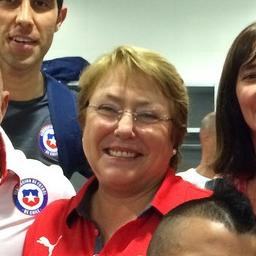

In [125]:
from IPython.display import Image
Image(labels_csv["image_path"][3])

In [126]:
import numpy as np
labels = labels_csv["label"].to_numpy()
labels

array(['real', 'real', 'fake', ..., 'real', 'fake', 'fake'], dtype=object)

In [127]:
unique_labels = np.unique(labels)
len(unique_labels)

2

In [128]:
unique_labels

array(['fake', 'real'], dtype=object)

In [129]:
boolean_labels = [label == unique_labels for label in labels]
boolean_labels[3]

array([False,  True])

In [130]:
print(labels[0]) # original label
print(np.where(unique_labels == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

real
(array([1]),)
1
[0 1]


In [131]:
X = labels_csv
y = boolean_labels

In [132]:
len(X)

112000

In [133]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000}

In [134]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES],
                                                 test_size=0.2,
                                                 random_state=42)

len(X_train),len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [135]:
X_train[:5], y_train[:2]

(                                            image_path label
 29   /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  fake
 535  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  fake
 695  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
 557  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
 836  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real,
 [array([ True, False]), array([ True, False])])

# Turning image into Tensors

In [136]:
from matplotlib.pyplot import imread
image = imread(labels_csv["image_path"][42])
image.shape

(256, 256, 3)

In [137]:
image.max(), image.min()

(255, 0)

In [138]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 256, 3), dtype=uint8, numpy=
array([[[ 90,  92,  81],
        [ 88,  90,  79],
        [ 85,  87,  76],
        ...,
        [151, 137, 108],
        [148, 134, 105],
        [146, 132, 103]],

       [[ 87,  90,  79],
        [ 86,  89,  78],
        [ 84,  87,  76],
        ...,
        [151, 137, 108],
        [148, 134, 105],
        [146, 132, 103]]], dtype=uint8)>

In [139]:
#define image size
IMG_SIZE = 224

# Create a function for preprocessing

def process_image(image_path):
  """
    Takes an image file path and turns it inot tensor
  """

  #read in an image file
  image = tf.io.read_file(image_path)

  # turn the jpeg image into numerical tensors with 3 colors channel (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # NORMALISATION
  #convert the colour chanel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # resize the image to our desired (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image



In [140]:
# Create a simple function to return a tuple (image, tuple)


def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [141]:
#define the batch size, 32 is good
BATCH_SIZE = 32;

# Create a function to turn into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  #IF the data is the test data set we probably don't have labels
  if test_data:
    print("Creating test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a valid dataset, we don't need to shuffle it.
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [142]:
# Creating training and validation data batches

train_data = create_data_batches(X_train['image_path'], y_train)
val_data = create_data_batches(X_val['image_path'], y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [143]:
train_data.element_spec, val_data.element_spec
# len(train_data)

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [144]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels from a data batch.
  """
  # setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)

  for i in range(25):
    # create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1);
    # display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_labels[labels[i].argmax()])
    # turn the grid lines off
    plt.axis("off")

In [145]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>

In [146]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [147]:
len(train_images), len(train_labels)

(32, 32)

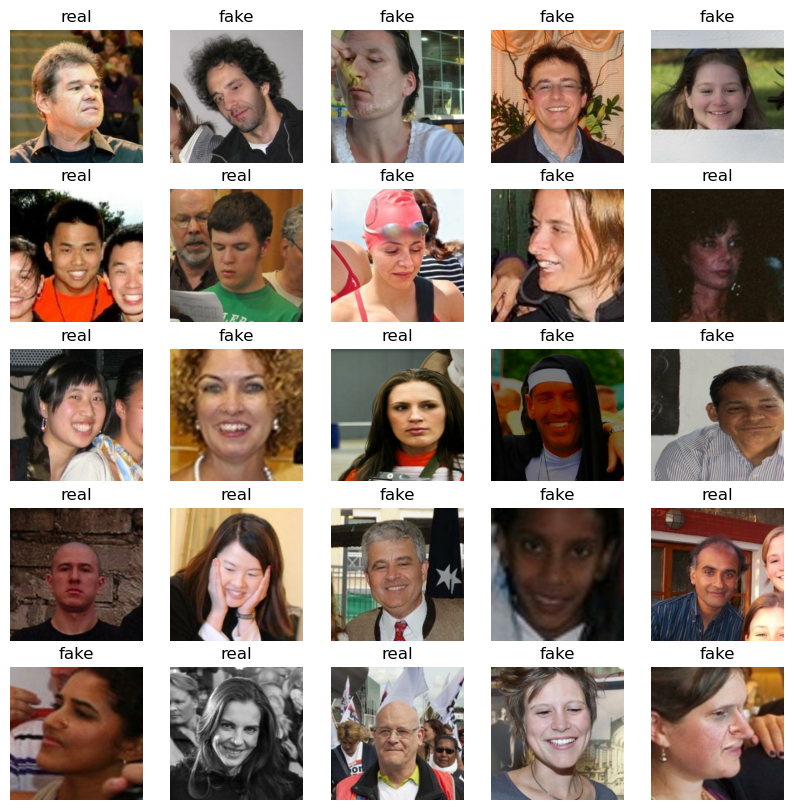

In [148]:
show_25_images(train_images, train_labels)

Model Training

In [149]:
IMG_SIZE = 224

In [150]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape to the model
OUTPUT_SHAPE = len(unique_labels)

# Setup model URL fom Tensorflow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/2"

In [151]:
OUTPUT_SHAPE = len(unique_labels)

def create_model(input_shape=INPUT_SHAPE, output_shape: int = OUTPUT_SHAPE):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(output_shape, activation='softmax')
    ])
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    model.build(input_shape)

    return model

In [152]:
# def create_model(input_shape=INPUT_SHAPE, output_shape: int =OUTPUT_SHAPE, model_url: str =MODEL_URL):
#   print("Building the model with: ", MODEL_URL)

#   # setup the model layers
#   model = tf.keras.Sequential([
#         hub.KerasLayer(MODEL_URL),
#         tf.keras.layers.Dense(units=OUTPUT_SHAPE,
#                               activation="softmax") #layer 2 (output layer)
#   ])

#     # compile the model
#   model.compile(
#       loss=tf.keras.losses.CategoricalCrossentropy(),
#       optimizer=tf.keras.optimizers.Adam(),
#       metrics=["accuracy"]
#   )

#   model.build(INPUT_SHAPE)

#   return model

In [153]:
model = create_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [154]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [155]:
import datetime

# create a function to build tensorboard callback

def create_tensorboard_callback():
  # create a log directory for storing Tensorboard logs
  logdir = os.path.join("drive/MyDrive/DeepFake/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

In [156]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [157]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [158]:
# Check to make sure we're still using CPU
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU not available :(


In [159]:
import os

In [160]:
# Build a function to train and return a trained model

def train_model():
  """
   Train a given model and returns the trained version.
  """

  #create a model
  model = create_model()

  #Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data, passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping]
            )

  # Return the fitted model
  return model


In [161]:
# fit the model to the data
# model = train_model()

In [169]:
def save_model(model, suffix=None):
  """
  Save a given model in a models directory in the project folder and appends a suffix (string)
  """
  # tfjs.converters.save_keras_model(model, '')
  # Create a model directory pathname with current time

  modeldir = os.path.join("./",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [170]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label (prediction_probabilities):
  """
    Turns an array of predicition probabilities into a label.
  """

  return unique_labels[np.argmin(prediction_probabilities)]


In [171]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [172]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>

In [166]:
# create a function yo unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  #Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]


2024-04-29 10:36:36.717278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[0.74035615, 0.79525816, 0.6972189 ],
         [0.729972  , 0.784874  , 0.6885154 ],
         [0.7078431 , 0.76274514, 0.672549  ],
         ...,
         [0.03445382, 0.04229696, 0.03837539],
         [0.03585434, 0.04369748, 0.03977591],
         [0.03923576, 0.0470789 , 0.04315733]],
 
        [[0.7352941 , 0.7901961 , 0.6938375 ],
         [0.7284714 , 0.78319335, 0.6886955 ],
         [0.7073029 , 0.7613646 , 0.6736895 ],
         ...,
         [0.04425775, 0.05210089, 0.04817932],
         [0.04565827, 0.0535014 , 0.04957984],
         [0.04565827, 0.0535014 , 0.04957984]],
 
        [[0.7236295 , 0.7771309 , 0.6911365 ],
         [0.71876746, 0.77172875, 0.6873549 ],
         [0.70162064, 0.7526011 , 0.67416966],
         ...,
         [0.05680275, 0.06464589, 0.06072432],
         [0.05770309, 0.06554622, 0.06162465],
         [0.05770309, 0.06554622, 0.06162465]],
 
        ...,
 
        [[0.32240918, 0.26358566, 0.23613468],
         [0.32240918, 0.26358566, 0.23613

In [173]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  #Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])


  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediciton and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob*100),
                                    true_label),
                                    color=color)


In [174]:
# save our model tarined
save_model(model, suffix="100-images-mobilenetv2-Adam")

saving model to: ./20240429-10371714367272-100-images-mobilenetv2-Adam.h5...


'./20240429-10371714367272-100-images-mobilenetv2-Adam.h5'

In [175]:
model = load_model("./20240428-18221714308756-100-images-mobilenetv2-Adam.h5")

Loading saved model from: ./20240428-18221714308756-100-images-mobilenetv2-Adam.h5


In [ ]:
predictions = model.predict(val_data, verbose=1)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step


array([[0.4372579 , 0.56274205],
       [0.6978548 , 0.3021452 ],
       [0.62238127, 0.37761867],
       [0.2998798 , 0.7001203 ],
       [0.832848  , 0.1671519 ],
       [0.43879694, 0.561203  ],
       [0.66982055, 0.33017948],
       [0.6478421 , 0.35215795],
       [0.8630556 , 0.13694438],
       [0.38075143, 0.6192486 ],
       [0.45124924, 0.54875076],
       [0.6894174 , 0.3105826 ],
       [0.41278353, 0.5872165 ],
       [0.7455243 , 0.25447574],
       [0.55597943, 0.44402048],
       [0.8319056 , 0.1680943 ],
       [0.5224867 , 0.47751325],
       [0.4214836 , 0.5785163 ],
       [0.55334723, 0.4466527 ],
       [0.7263251 , 0.2736749 ],
       [0.8649828 , 0.1350172 ],
       [0.6883065 , 0.3116935 ],
       [0.47881323, 0.5211868 ],
       [0.8819717 , 0.11802822],
       [0.49981672, 0.5001832 ],
       [0.740794  , 0.25920597],
       [0.4958775 , 0.5041225 ],
       [0.5590623 , 0.44093767],
       [0.8802171 , 0.11978292],
       [0.53290534, 0.46709466],
       [0.

In [176]:
predictions.shape

(200, 2)

In [177]:
np.sum(predictions[0])

0.99999994

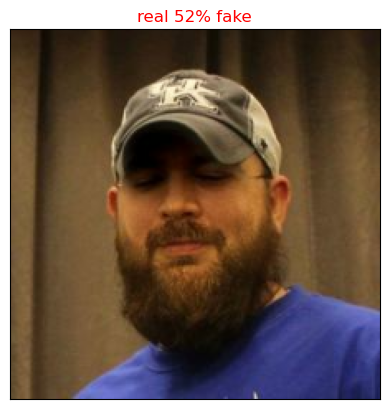

In [178]:
plot_pred(predictions, val_labels, val_images,16)

In [179]:
def plot_pred_config(prediciton_probabilities, labels, n=1):
  """
  View the predictionn, ground truth and image for sample n
  """
  pred_prob, true_label = prediciton_probabilities[n], labels[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 predicition confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plots
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                   top_10_pred_values,
                   color="grey")


  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label

  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass



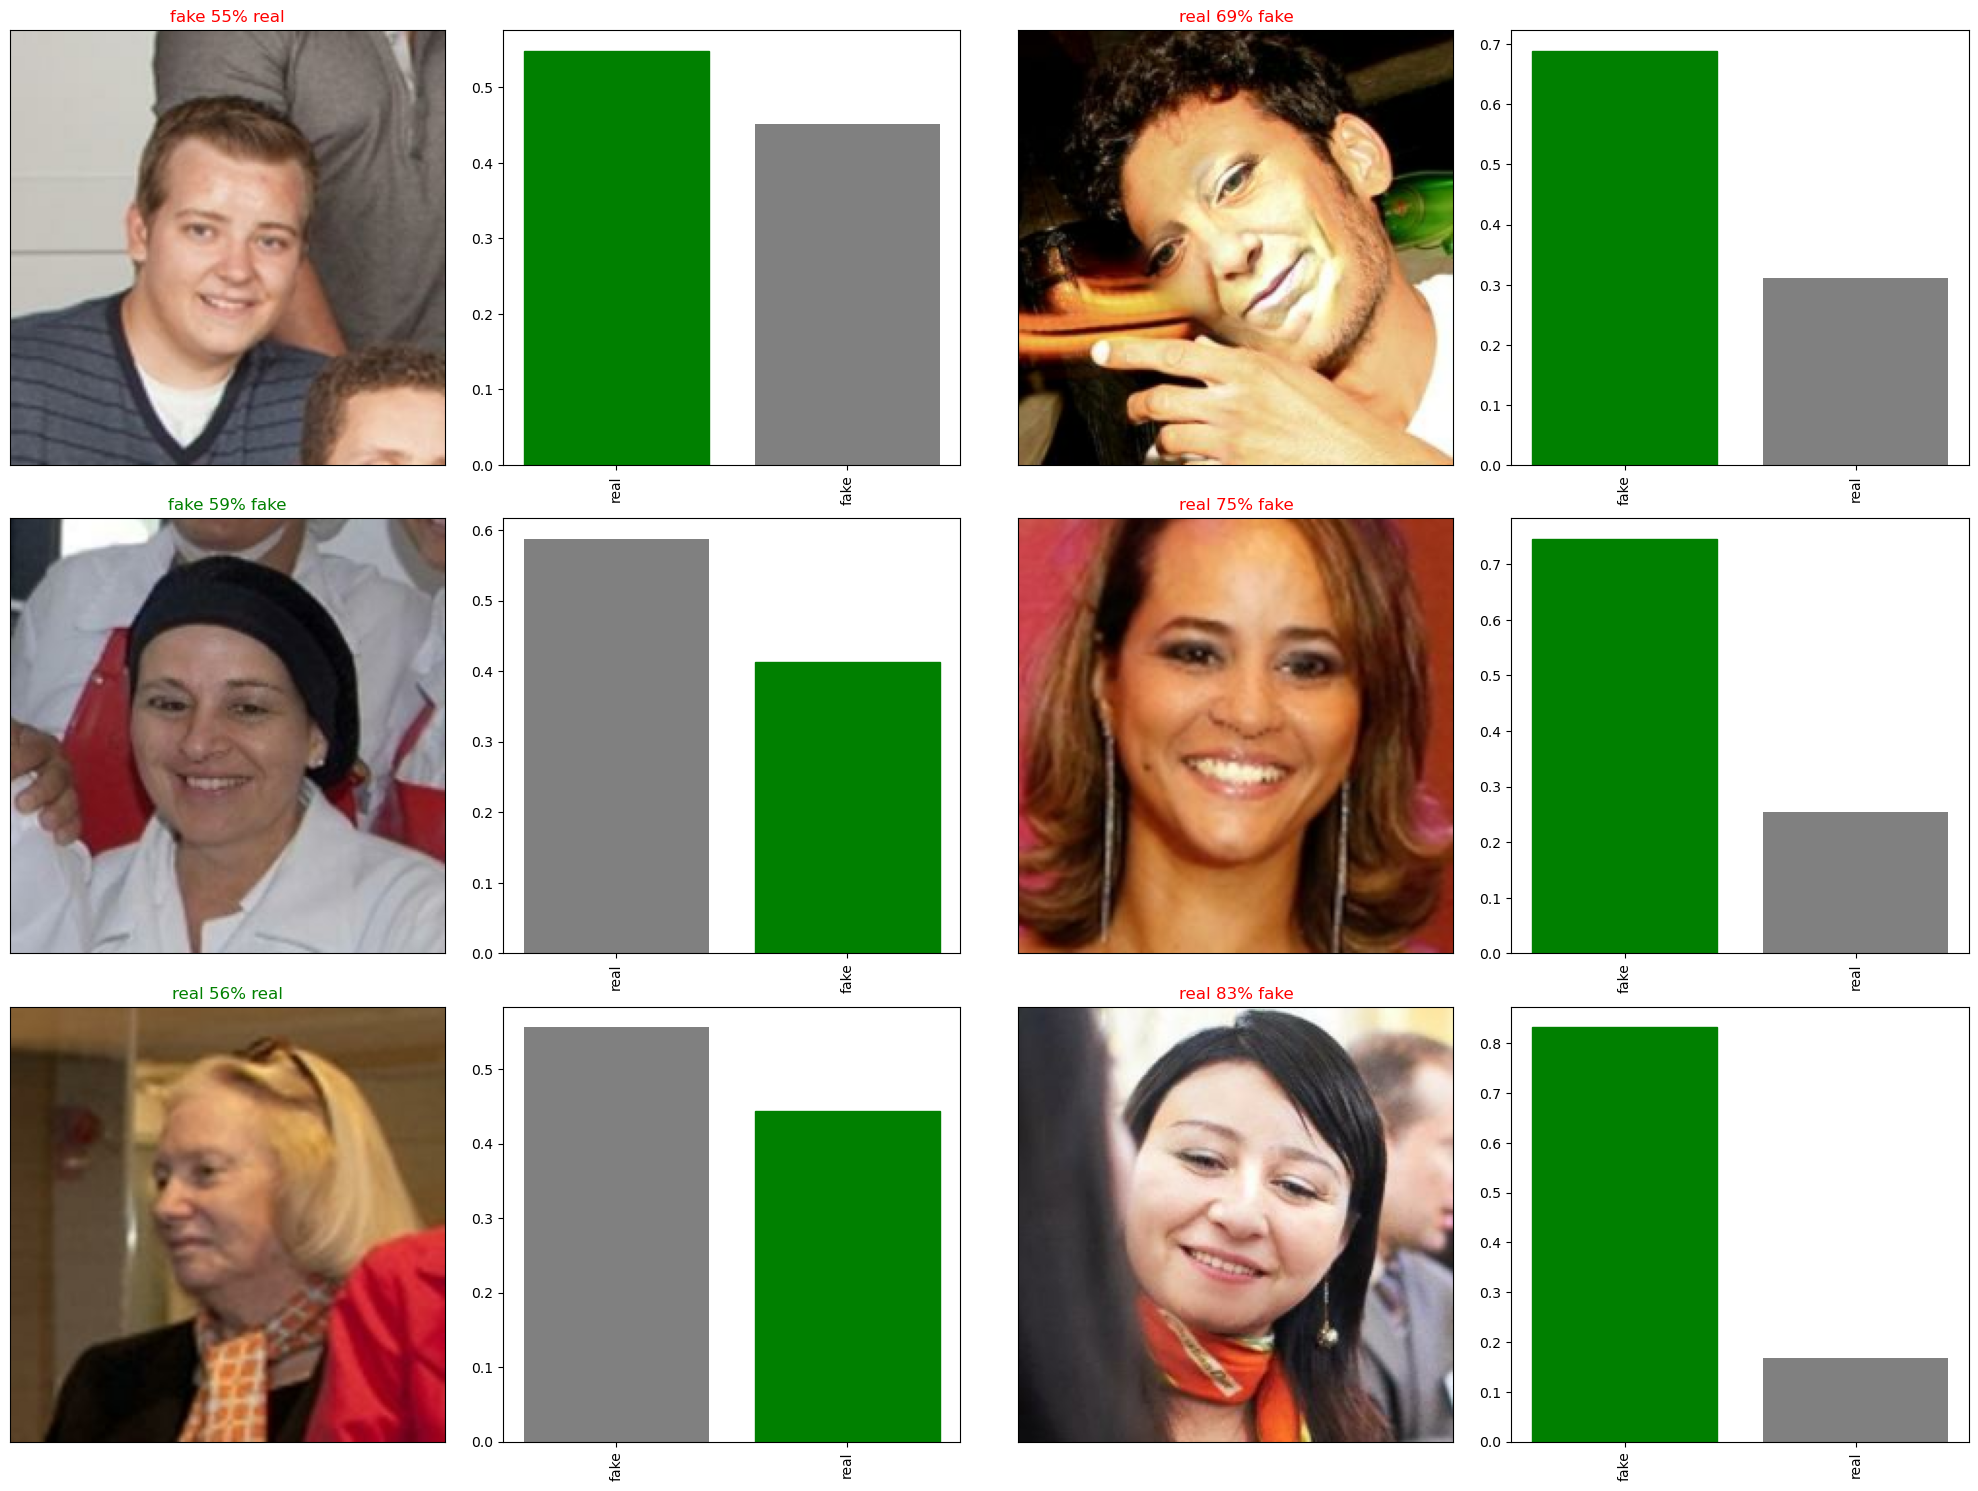

In [180]:
# Lets check out a few predicitions and their different values

i_multiplier = 10;
num_rows = 3;
num_cols = 2;
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)

  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_config(predictions, val_labels, i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

In [181]:
loaded_100_image_model = load_model("20240428-18221714308756-100-images-mobilenetv2-Adam.h5")

Loading saved model from: 20240428-18221714308756-100-images-mobilenetv2-Adam.h5


In [182]:
loaded_100_image_model.evaluate(val_data) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.4943 - loss: 0.8290


[0.8172910213470459, 0.5049999952316284]

# 5000 Data Set Training

In [183]:
len(X), len(y)

(112000, 112000)

In [184]:
# Set number of images to use for experimenting
NUM_IMAGES = 5000 #@param {type: "slider", min:1000, max:10000}

In [185]:
mid_data = create_data_batches(X["image_path"][:NUM_IMAGES], y[:NUM_IMAGES])

Creating training data batches...


In [186]:
mid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>

In [187]:
# Create a model
mid_model = create_model()

In [188]:
# create full model callbacks
mid_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
mid_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [189]:
# mid_model.fit(x=mid_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[mid_model_tensorboard, mid_model_early_stopping])

In [190]:
# save_model(mid_model, suffix="mid-5000-image-set-mobilenetv2-Adam")

In [191]:
loaded_mid_model = load_model("20240428-18221714308756-100-images-mobilenetv2-Adam.h5")

Loading saved model from: 20240428-18221714308756-100-images-mobilenetv2-Adam.h5


In [192]:
loaded_mid_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,548 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [193]:
test_data = pd.read_csv("./image_labels_test.csv")
print(test_data.describe())
print(test_data.head())

                                               image_path  label
count                                               28002  28002
unique                                              28002      2
top     /Users/lavanyajain/Desktop/Innohacks/Dataset/T...   real
freq                                                    1  14001
                                          image_path label
0  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
1  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  fake
2  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
3  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  real
4  /Users/lavanyajain/Desktop/Innohacks/Dataset/T...  fake


In [194]:
final_test_set = test_data[:2000]

In [195]:
len(final_test_set)

2000

In [196]:
final_test_data = create_data_batches(final_test_set["image_path"], test_data=True)

Creating test data batches


In [197]:
test_pedictions = loaded_mid_model.predict(final_test_data, verbose=True)

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step


In [198]:
custom_pred_labels = [get_pred_label(test_pedictions[i]) for i in range(len(test_pedictions))]
custom_pred_labels[:5]

['real', 'fake', 'fake', 'real', 'real']

In [199]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in final_test_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

2024-04-29 10:39:24.665895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [200]:
test_data = ["/Users/lavanyajain/Desktop/Innohacks/images.jpeg"]

In [201]:
test_data = create_data_batches(test_data, test_data=True)
test_data

Creating test data batches


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [202]:
custom_preds = loaded_mid_model.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [203]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['fake']

In [204]:
custom_images = []
# Loop through unbatched data
for image in test_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

2024-04-29 10:39:34.799052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
